# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('data/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [7]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Разбейте данные на выборки

In [8]:
features = df.drop(['is_ultra'],axis=1)
target = df['is_ultra']

Разобьем выборку на обучающую(60%), валидационную(20%) и тестовую(20%).

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [11]:
print('Размер обучающей выборки:', features_train.shape[0])
print('Размер валидационной выборки:', features_valid.shape[0])
print('Размер тестовой выборки:',features_test.shape[0])

Размер обучающей выборки: 1928
Размер валидационной выборки: 643
Размер тестовой выборки: 643


## Исследуйте модели

Обучим модель дерева решений

In [12]:
best_accuracy = 0
best_depth = 0
depths=[]
dtc_acc=[]
tree_model=None
for depth in range(1,20):
    model = DecisionTreeClassifier(random_state=12345,max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid=model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    depths.append(depth)
    dtc_acc.append(accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
        tree_model=model
print("Best depth:", best_depth, "Best accuracy:", best_accuracy)

Best depth: 3 Best accuracy: 0.7853810264385692


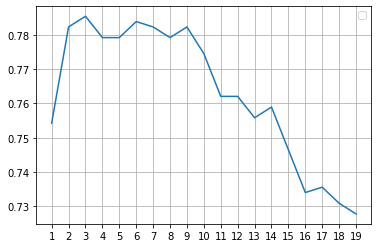

In [13]:
dtc=sns.lineplot(data=pd.DataFrame(data=dtc_acc,index=depths),dashes=False)
dtc.set(xticks=depths)
plt.legend('')
plt.grid() 
plt.show()

Лучшие показатели точности приходятся на глубину дерева равную 3.

Обучим логистическую регрессию

In [14]:
logic_model = LogisticRegression(random_state=12345) 
logic_model.fit(features_train,target_train) 
result = logic_model.score(features_valid,target_valid)
print('Best score:',result)

Best score: 0.7589424572317263


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Обучим модель случайный лес

In [15]:
forest_model = None
best_result = 0
best_depth=0
best_est=0
best_sample=0
for est in range(1, 50):
    for depth in range(1,10):
        for sample in range(1,5):
            model = RandomForestClassifier(random_state=12345, n_estimators=est,max_depth = depth,min_samples_leaf=sample) 
            model.fit(features_train,target_train) 
            result = model.score(features_valid, target_valid)
            if result > best_result:
                forest_model = model
                best_result = result 
                best_depth=depth
                best_est=est
                best_sample=sample

print("Accuracy:", best_result,'Depth:',best_depth,'Est:',best_est,'Sample:',best_sample)

Accuracy: 0.8102643856920684 Depth: 6 Est: 34 Sample: 2


Лучшие показатели точности (0.81) приходятся на значения гиперпараметров n_estimators=34,max_depth = 6,min_samples_leaf=2

Таким образом наиболее точной является модель случайного леса, далее идет модель дерева решений, на последнем месте логистическая регрессия. По показателям скорости обучения случайный лес проигрывает другим моделям

## Проверьте модель на тестовой выборке

In [16]:
tree_model.score(features_test, target_test)

0.7791601866251944

In [17]:
logic_model.score(features_test, target_test)

0.7402799377916018

In [18]:
forest_model.score(features_test, target_test)

0.7962674961119751

Наилучшие показатели точности (0.796) на тестовой выборке достигаются при использовании Random Forest с гиперпараметрами n_estimators=34,max_depth = 6,min_samples_leaf=2

Для проверки наших моделей на адекватность используем DummyClassifier

In [19]:
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(features_train, target_train)
dummy.score(features_test, target_test)

0.6842923794712286

Как видно в наших моделях точность прогноза выше чем при использовании DummyClassifier, отсюда следует, что наши модели адекватны

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
